In [133]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from itertools import product
import time

### utility func

In [5]:
def save_pred_to_csv(pred, msg='', dir_name='../predictions/'):
    """
    save prediction results to csv.
    
    Add time as idfier. Other info can be passed to msg.
    
    Args:
        pred(DataFrame): prediction result.
        
        msg(str): extra message want to include in file_name
        
        dir(name): directory name
        
    Return None
    """
    try:
        pred = pred[['ID', 'item_cnt_month']]
    except:
        raise Exception('ID or item_cnt_month column not found')
    
    str_datetime = datetime.now().strftime("%m%d_%H_%M")
    full_name = dir_name + msg + '_' + str_datetime + '.csv'
    
    pred.to_csv(full_name, index=False)
    

In [136]:
data_dir = os.path.dirname(os.getcwd()) + '/data/'
files = os.listdir(data_dir)

train = pd.read_csv(data_dir + files[1])
test = pd.read_csv(data_dir + files[3])

shops = pd.read_csv(data_dir + files[2])
item_cat = pd.read_csv(data_dir + files[4])
item = pd.read_csv(data_dir + files[5])
sample_sub = pd.read_csv(data_dir + files[6])

In [137]:
test.shape

(214200, 3)

In [138]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### select those shop and items that appears in test. (think of ways to utilize those unpresanted later)

In [116]:
train_lk = train[train.shop_id.isin(test.shop_id.unique())]
train_lk = train_lk[train_lk.item_id.isin(test.item_id.unique())]
print('train_lk shape: ', train_lk.shape)

train_lk shape:  (1224439, 6)


### generate month sum and month mean

In [117]:
train_lk_gp = train_lk.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_lk = train_lk_gp.agg({'item_cnt_day': ['sum', 'mean']})
train_lk.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_cnt_mean']

cnt_bound = train_lk.item_cnt_month.quantile(0.99)
mean_bound = train_lk.item_cnt_mean.quantile(0.99)
print('item_cnt_month 99% quantile: ', cnt_bound)
print('item_cnt_mean 99% quantile: ', mean_bound)
# clip item_cnt_month between [0, 21] and item_cnt_mean between [0, 2.5]
train_lk['item_cnt_month'] = train_lk['item_cnt_month'].clip(lower=0, upper=cnt_bound)
train_lk['item_cnt_mean'] = train_lk['item_cnt_mean'].clip(lower=0, upper=mean_bound)

item_cnt_month 99% quantile:  21.0
item_cnt_mean 99% quantile:  2.5


(array([1.16500e+03, 2.00000e+00, 5.06000e+02, 2.00000e+00, 4.41000e+02,
        1.72000e+02, 2.10000e+02, 4.80000e+01, 5.33813e+05, 1.08690e+04,
        1.62730e+04, 3.55800e+03, 1.14150e+04, 2.74200e+03, 1.63400e+03,
        4.40000e+02, 9.19400e+03, 4.83000e+02, 6.49000e+02, 6.54300e+03]),
 array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
        1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
        2.25 , 2.375, 2.5  ]),
 <a list of 20 Patch objects>)

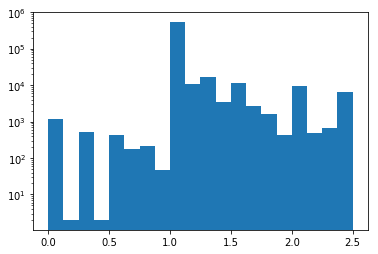

In [118]:
plt.hist(train_lk.item_cnt_mean, bins=20, log=True)

(array([360634., 109854.,  45773.,  24321.,  15026.,   9838.,   6600.,
          4972.,   3553.,   2810.,   2082.,   1714.,   1482.,   1161.,
          1003.,    836.,    761.,    628.,    570.,   6541.]),
 array([ 0.  ,  1.05,  2.1 ,  3.15,  4.2 ,  5.25,  6.3 ,  7.35,  8.4 ,
         9.45, 10.5 , 11.55, 12.6 , 13.65, 14.7 , 15.75, 16.8 , 17.85,
        18.9 , 19.95, 21.  ]),
 <a list of 20 Patch objects>)

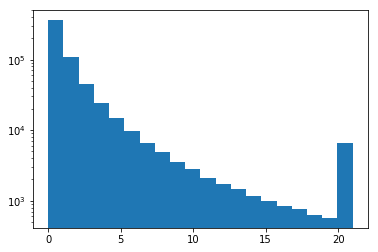

In [119]:
plt.hist(train_lk.item_cnt_month, bins=20, log=True)

### Generate cartisian products of date_block_num, shop_id, item_id

In [120]:
car_prod = np.array(list(product(*[train_lk.date_block_num.unique(), train_lk.shop_id.unique(), train_lk.item_id.unique()])))
train_car = pd.DataFrame(car_prod, columns=['date_block_num', 'shop_id', 'item_id'])
print('train_cartisian shape: ', train_car.shape)

train_lk = pd.merge(train_car, train_lk, how='left', on=['date_block_num', 'shop_id', 'item_id'])
train_lk.fillna(0, inplace=True)

train_cartisian shape:  (6734448, 3)


In [121]:
train_lk.head(2)

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_mean
0,0,2,33,1.0,1.0
1,0,2,482,1.0,1.0


### Add lag features

In [122]:
lags = [1, 2, 3]

for lag in lags:
    train_lk['item_cnt_month_lag_' + str(lag)] = train_lk.sort_values('date_block_num')\
    .groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)
    train_lk['item_cnt_mean_lag_' + str(lag)] = train_lk.sort_values('date_block_num')\
    .groupby(['shop_id', 'item_id'])['item_cnt_mean'].shift(lag)

### Add month feature

In [123]:
train_lk['month'] = train_lk['date_block_num'] % 12

### Identify target

Since our job is to predict the next month salses, the target should be next month sales not the current month!

In [124]:
train_lk['target'] = train_lk.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(-1)
train_lk.tail()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_mean,item_cnt_month_lag_1,item_cnt_mean_lag_1,item_cnt_month_lag_2,item_cnt_mean_lag_2,item_cnt_month_lag_3,item_cnt_mean_lag_3,month,target
6734443,33,36,9103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,NaN
6734444,33,36,9107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,NaN
6734445,33,36,10204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,NaN
6734446,33,36,12733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,NaN
6734447,33,36,15925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,NaN


### Train, val, test splitting

In [125]:
df_train = train_lk[(train_lk.date_block_num > 2) & (train_lk.date_block_num < 30)]
df_val = train_lk[(train_lk.date_block_num >=30) & (train_lk.date_block_num <= 32)]
df_test = pd.merge(test, train_lk[train_lk.date_block_num == 33], how='left', on=['shop_id', 'item_id'])\
    .drop('target', axis=1)

### Mean encoding

In [126]:
enc_cols = ['shop_id', 'item_id', 'month']

for col in enc_cols:
    df_enc = df_train.groupby(col, as_index=False).agg({'target': 'mean'}).rename({'target': col + '_mean_enc'}, axis=1)
    
    df_train = df_train.merge(df_enc, on=col, how='left')
    df_val = df_val.merge(df_enc, on=col, how='left')
    df_test = df_test.merge(df_enc, on=col, how='left')


In [128]:
train_cols = ['shop_id', 'item_id', 'item_cnt_month', 'item_cnt_mean', 'item_cnt_month_lag_1', 'item_cnt_mean_lag_1', 
              'month', 'item_cnt_month_lag_2', 'item_cnt_mean_lag_2', 'item_cnt_month_lag_3', 'item_cnt_mean_lag_3',
             'shop_id_mean_enc', 'item_id_mean_enc', 'month_mean_enc']
label_col = 'target'

x_train, y_train = df_train[train_cols], df_train[label_col]
x_val, y_val = df_val[train_cols], df_val[label_col]

### Fill NAs in Test with zeros

In [129]:
x_test = df_test[train_cols]
x_test.fillna(0, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [130]:
x_test.isnull().sum()

shop_id                 0
item_id                 0
item_cnt_month          0
item_cnt_mean           0
item_cnt_month_lag_1    0
item_cnt_mean_lag_1     0
month                   0
item_cnt_month_lag_2    0
item_cnt_mean_lag_2     0
item_cnt_month_lag_3    0
item_cnt_mean_lag_3     0
shop_id_mean_enc        0
item_id_mean_enc        0
month_mean_enc          0
dtype: int64

### Gradient boosting tree

In [131]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [132]:
params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 1.0,
    'random_state': 41
}


gbr = GradientBoostingRegressor(**params)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=41,
             subsample=1.0, verbose=0, warm_start=False)

In [134]:
y_pred_train = gbr.predict(x_train)
print('train RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred_train)))
y_pred_val = gbr.predict(x_val)
print('validation RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred_val)))

train RMSE:  0.7878361503843763
validation RMSE:  0.9178575199731875


In [135]:
y_pred_test = gbr.predict(x_test)
pred_test = test.copy()
pred_test['item_cnt_month'] = y_pred_test
save_pred_to_csv(pred_test, msg='three_month_lag-zero_fill_shop_item_month_mean_enc')

with outlier
train RMSE:  1.8482461723357235
validation RMSE:  3.116295303446713

without outlier
train RMSE:  0.8136265756274446
validation RMSE:  0.9271415425647744

with shop, item, month mean encoding
train RMSE:  0.783626998745065
validation RMSE:  0.9236206120907205

with shop, item, month mean encoding plus 2, 3 month lag
train RMSE:  0.7878361503843763
validation RMSE:  0.9178575199731875